import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import talib as ta
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
from database import engine

### Technical Analysis

### ML Classification Model for Stock Market Prediction

In [23]:
def add_features(df):
    ''' This function takes the stock dataframe, adds to it new columns of different technical indicators as predictive variables for the model to use. '''
      
    n=7
    df['RSI'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)
    df['MA'] = df['Close'].shift(1).rolling(window=n).mean()
    df['Corr'] = df['Close'].shift(1).rolling(window=n).corr(df['MA'].shift(1))
    df['SAR'] = ta.SAR(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), 0.2, 0.2)
    df['ADX'] = ta.ADX(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), np.array(df['Open']), timeperiod=n)
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)
    df['Prev_Close'] = df['Close'].shift(1)
    df['Open_change'] = df['Open'] - df['Open'].shift(1)
    df['Open_close_change'] = df['Open'] - df['Prev_Close']
    df['Return'] = (df['Open'].shift(-1) - df['Open']) / df['Open']
    df['return_lag1'] = df['Return'].shift(1)
    df['return_lag2'] = df['Return'].shift(2)
    df['return_lag3'] = df['Return'].shift(3)
    df = df.dropna()
    
    return df 

In [24]:
def add_signals(df):
    ''' This function takes a dataframe and adds a new column for signals, the signals are based on the distribution of the observed returns of the stock during the
        selected period, a 'Sell' signal will be assigned for all observed returns that lie below the 40th quantile (negative returns) to signal a predicted loss, 
        similarly a 'Buy' signal will be assigned for all observed returns that lie above the 60th quantile (positive returns) to signal a predicted gain, and 
        a 'Hold' signal otherwise, mostly small percentage changes in returns. '''
    
    df['Signal'] = 'Hold'
    df.loc[df['Return'] > df['Return'].quantile(q=0.60), 'Signal'] = 'Buy'
    df.loc[df['Return'] < df['Return'].quantile(q=0.40), 'Signal'] = 'Sell'
    
    return df

In [25]:
def get_training_split(df):
    ''' This function takes a dataframe and returns one dataframe and one pandas series, the returned dataframe conatins the features of the training dataset,
        and the returned series contain the related signals of the training dataset. '''
    
    split = int(len(df)*0.8)
    
    features = df.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'Return'], axis=1)
    signals = df['Signal']
    
    training_features_df = features[:split]
    training_signals_series = signals[:split]
    
    return training_features_df, training_signals_series;

In [26]:
def get_testing_split(df):
    ''' This function takes a dataframe and returns one dataframe and one pandas series, the returned dataframe conatins the features of the testing dataset,
         and the returned series contains the related signals of the testing dataset. '''
    
    split = int(len(df)*0.8)
    
    features = df.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'Return'], axis=1)
    signals = df['Signal']
    
    testing_features_df = features[split:]
    testing_signals_series = signals[split:]
    
    return testing_features_df, testing_signals_series;

In [27]:
def prediction_model(trainF, trainS, testF):
    ''' This function takes two dataframes and one pandas series. We will pass the training features dataframe, training actual signals series, 
        and the testing features dataframe that we want the model to predict. The function returns a pandas series of the predicted signals. '''
    
    c = [10,100,1000,10000]
    g = [1e-2, 1e-1, 1e0]
    parameters = {'svc__C' : c,
                  'svc__gamma': g,
                  'svc__kernel': ['rbf']
                 }
    steps = [('scaler', StandardScaler()), ('svc', SVC())]
    pipeline = Pipeline(steps)
    
    rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))
    rcv.fit(trainF, trainS)
    best_C = rcv.best_params_['svc__C']
    best_kernel = rcv.best_params_['svc__kernel']
    best_gamma = rcv.best_params_['svc__gamma']
    
    cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)
    ss = StandardScaler()
    
    cls.fit(ss.fit_transform(trainF), trainS)
    predicted_signals = cls.predict(ss.transform(testF))
    
    return predicted_signals

In [28]:
def plot_confusion_matrix(array):
    ''' This function takes an array (confusion matrix) and returns a plot to visualise the performance. '''
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax = plt.subplot()
    sns.heatmap(array, annot=True, ax=ax)

    ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
    ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
    
    return plt.show()

In [29]:
def classification_model_evaluation(df):
    ''' This function takes the stock's dataframe, mutates it in the desired format, splits the dataset into a training and testing datasets, gets the model predictions
         and evaluates it, and then returns the confusion matrix plot and the classification accuracy report (out-of-sample accuracy is based on the testing dataset). '''
    
    df1 = add_features(df)
    df2 = add_signals(df1)
    
    trainF, trainS = get_training_split(df2)
    testF, testS = get_testing_split(df2)
    
    predicted_signals = prediction_model(trainF, trainS, testF)
    
    confusion_matrix_ = confusion_matrix(testS, predicted_signals)
    confusion_matrix_plot = plot_confusion_matrix(confusion_matrix_)
    out_of_sample_accuracy = classification_report(testS, predicted_signals)
    
    return print(confusion_matrix_plot, out_of_sample_accuracy)

#### Model Evaluation

##### The model's performance varies from stock to stock, some stocks got a high accuracy rate ( > 50% ) and some other stocks were harder to accuratly predict ( < 50% ) and had a low accuracy rate. However, out of 15 randomly selected stocks we got an average accuracy rate of 58%. We listed four examples below. 

##### 1) Amazon

In [30]:
Amazon_query = """ 
select 
	v."Date" as "Date",
	op."AMZN" as "Open",
	hp."AMZN" as "High",
	lp."AMZN" as "Low",
	cp."AMZN" as "Close",
	ac."AMZN" as "Adj Close",
	v."AMZN" as "Volume"

FROM 
	close_price cp left join adj_close ac on cp."Date" = ac."Date"
	left join volume v on cp."Date" = v."Date"
	left join open_price op on cp."Date" = op."Date"
	left join high_price hp on cp."Date" = hp."Date"
	left join low_price lp on cp."Date" = lp."Date"

    """

In [31]:
amzn = pd.read_sql_query(Amazon_query, engine) # could not pass this to my function because I get a type error, so I used yfinance below.

In [ ]:
amzn = yf.download('AMZN', start ='2019-04-29', end = '2022-04-29')

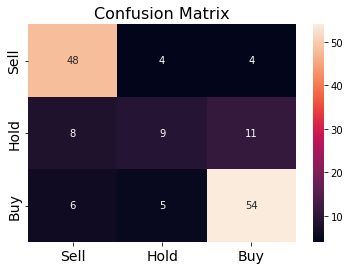

None               precision    recall  f1-score   support

         Buy       0.77      0.86      0.81        56
        Hold       0.50      0.32      0.39        28
        Sell       0.78      0.83      0.81        65

    accuracy                           0.74       149
   macro avg       0.69      0.67      0.67       149
weighted avg       0.73      0.74      0.73       149



In [34]:
classification_model_evaluation(amzn)

###### The model's accuracy in predicting Amazon's stock movement direction is 74%. 

##### 2) Boeing

In [37]:
Boeing = yf.download('BA', start ='2019-04-29', end = '2022-04-29')

[*********************100%***********************]  1 of 1 completed


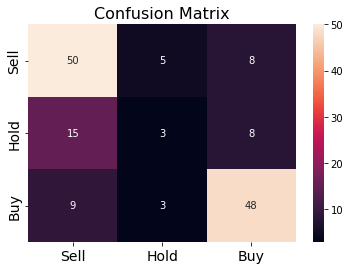

None               precision    recall  f1-score   support

         Buy       0.68      0.79      0.73        63
        Hold       0.27      0.12      0.16        26
        Sell       0.75      0.80      0.77        60

    accuracy                           0.68       149
   macro avg       0.57      0.57      0.56       149
weighted avg       0.64      0.68      0.65       149



In [38]:
classification_model_evaluation(Boeing)

###### The model's accuracy in predicting Boeing's stock movement direction is 68%. 

##### 3) eBay

In [39]:
ebay = yf.download('EBAY', start ='2019-04-29', end = '2022-04-29')

[*********************100%***********************]  1 of 1 completed


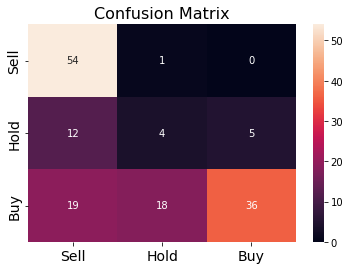

None               precision    recall  f1-score   support

         Buy       0.64      0.98      0.77        55
        Hold       0.17      0.19      0.18        21
        Sell       0.88      0.49      0.63        73

    accuracy                           0.63       149
   macro avg       0.56      0.56      0.53       149
weighted avg       0.69      0.63      0.62       149



In [40]:
classification_model_evaluation(ebay)

###### The model's accuracy in predicting eBay's stock movement direction is 63%. 

##### 4) Allstate

In [56]:
allstate = yf.download('ALL', start ='2019-04-29', end = '2022-04-29')

[*********************100%***********************]  1 of 1 completed


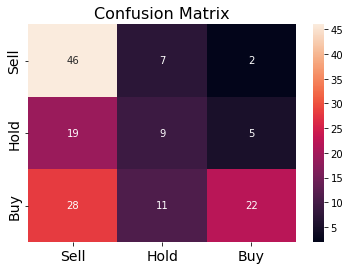

None               precision    recall  f1-score   support

         Buy       0.49      0.84      0.62        55
        Hold       0.33      0.27      0.30        33
        Sell       0.76      0.36      0.49        61

    accuracy                           0.52       149
   macro avg       0.53      0.49      0.47       149
weighted avg       0.57      0.52      0.50       149



In [57]:
classification_model_evaluation(allstate)

### Stock Market Prediction Using Prophet Package



In [143]:

# data access function 


regex = re.compile("[0-9]{4}\-[0-9]{2}\-[0-9]{2}")

def check_date_format(date):
    match = re.match(regex, date)
    
    if (match):
        return date
    elif date == 'q':
        return None
    else: 
       return check_date_format(input("Invalid date, try again or press 'q' to quit: "))
        
   
def get_initial_data(stockname, start_date, end_date):
    '''for start date and end date, means the start and end dates of the stocks you want to collect'''
    # stockname = stockname    
    # start_date = select_start_date
    # end_date = select_end_date
    data = yf.download(stockname, start = start_date, end = end_date)
    return data




In [144]:
def get_prophet_data(data):
    data['ds'] = data.index
    data_prophet = data[['ds', 'Close']]
    data_prophet = data_prophet.rename(columns = {'Close': 'y'})
    return data_prophet



def future_price_prediction(dataframe, periods):
    '''let users choose how long they wnat to use Prophet to estimate, it will give use the latest result as the predicted table is too long.'''
    m.fit(dataframe)
    future = m.make_future_dataframe(periods = periods_q)
    forecast = m.predict(future)
    latest_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    return latest_pred


# future_price_prediction(dataframe, periods_q)  

In [145]:
# prediction plot, shadow area shows the estimated interval
def Prophet_prediction_plot(dataframe, periods):
    '''show the prediction result compare to real price'''
    m = Prophet()
    m.fit(dataframe)
    future = m.make_future_dataframe(periods = periods_q) 
    forecast = m.predict(future)
    m.plot(forecast)
    m.plot_components(forecast)


In [158]:
# show the prediction result with line chat

# this code I wish I can run in sql, but I failed
# future = m.make_future_dataframe(periods = periods_q)
# forecast = m.predict(future)
# stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# data_combine = pd.merge(dataframe, stock_price_forecast, on = 'ds', how='outer')
# data_combine_inner = pd.merge(dataframe, stock_price_forecast, on = 'ds')
# data_combine['real price percent change'] = data_combine['y'].pct_change()
# data_combine['real price percent change'] = data_combine['real price percent change'].replace(np.nan, 0)

def prediction_need_table(data):
    m = Prophet()
    m.fit(dataframe)
    future = m.make_future_dataframe(periods = periods_q)
    forecast = m.predict(future)
    stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    data_combine = pd.merge(dataframe, stock_price_forecast, on = 'ds', how='outer')
    data_combine_inner = pd.merge(dataframe, stock_price_forecast, on = 'ds')
    data_combine['real price percent change'] = data_combine['y'].pct_change()
    data_combine['real price percent change'] = data_combine['real price percent change'].replace(np.nan, 0)
    return data_combine 

  


def estimation_result(dataframe):
    '''this function shows the estimated stock price by line chart rather than shadow areas'''
    '''the blue line is the real price, the yellow line is the estimated price,the green line and red line would be the estimated lower level and upper level respectively.'''
   
    dataframe.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(color=['royalblue', "yellow", "green", "red"], grid=True)



### Trade stategies

In [149]:
# Hold: Our bench mark. Simplest trading strategy, when we predict a stock will rise in price, 
# we hold until the last day of the prediction. 
# Any trading strategy is compared based on this trading strategy. 
# In this case, our theoretical calculation is based primarily on the magnitude of the actual price volatility, 
# which is a cumulative volatility range, 
# and I use '.cumprod()' to calculate it and make a separate column to see the investor's return on unit assets, 
# over a given time period.

def f_hold(row):
    if abs(row['real price percent change']) > 1 :
        val = 'sell'
    elif row['Hold_return on unit assets'] == 1.00000000:
        val = 'buy'
    else:
        val = 'hold'
    return val


def holding_strategy_table(data):
    '''This function create a table about holding strategy, include when we purchase, when we sold.'''
    holding_sum = data.copy()
    holding_sum['Hold_return on unit assets'] = (holding_sum['real price percent change'] + 1).cumprod()
    holding_sum['suggested strategy'] = holding_sum.apply(f_hold, axis=1)
    holding_sum_end = holding_sum[['ds', 'real price percent change','Hold_return on unit assets', 'suggested strategy']]
    return holding_sum_end


In [150]:
# Prophet: This strategy is to sell when our forecast indicates a down trend 
# and buy back in when it indicates an upward trend. In this case, 
# I set that when prophet forecasts the closing price for this stock (y_hat) 
# in the next day( t+1 day) is less than the closing price (y_hat) of today (t day), 
# I will sell all stocks, and then use the money I get to buy all the stocks on the next trading day (t+1 day). 


def f_prophet(row):
    if row['Prophet Strategy index'] < 0:
        val = 'sell and rebuy it tomorrow'
    elif row['Prophet Strategy index'] > 0:
        val = 'hold'
    else:
        val = 'buy'
    return val


def prophet_strategy_table(data):
    
    prophet_sum = data.copy()
    prophet_sum['Prophet Strategy return on unit assets'] = ((prophet_sum['yhat'].shift(-1) > prophet_sum['yhat']).shift(1) * (prophet_sum['real price percent change']) + 1).cumprod()
    prophet_sum['Prophet Strategy index'] = prophet_sum['yhat'].shift(-1) - prophet_sum['yhat']
    
    
    # prophet_sum.loc[prophet_sum['yhat'].shift(-1) > prophet_sum['yhat'], 'suggested strategy'] = "sell and rebuy it tomorrow"
    # prophet_sum.loc[prophet_sum['real price percent change'] == 0, 'suggested strategy'] = "buy"
    # prophet_sum.loc[prophet_sum['yhat'].shift(-1) <= prophet_sum['yhat'], 'suggested strategy'] = "hold"
    prophet_sum['suggested Strategy '] = prophet_sum.apply(f_prophet, axis=1,)
    # prophet_sum_end = prophet_sum[['ds', 'real price percent change','Prophet Strategy return on unit assets', 'suggested strategy']]
    return prophet_sum






In [151]:
# Prophet Thresh. This strategy is more confident. 
# If the real price of the day (day t) is lower than the low value we predicted the previous day (day t), 
# we will sell it all on the day (day t) and rebuy it again the next day(day t+1) with all the money.
def f_prophet_thresh(row):
    if row['Prophet Thresh Strategy index'] < 0:
        val = 'sell and rebuy it tomorrow'
    elif row['Prophet Thresh Strategy index'] > 0:
        val = 'hold'
    else:
        val = 'lack yesterday real closing price'
    return val


def prophet_thresh_strategy_table(data):
    prophet_thresh_sum = data.copy()
    prophet_thresh_sum['Prophet Thresh Strategy return on unit assets']  = ((prophet_thresh_sum['y'].shift(-1) > prophet_thresh_sum['yhat_lower']).shift(1)* (prophet_thresh_sum['real price percent change']) + 1).cumprod()
    prophet_thresh_sum['Prophet Thresh Strategy return on unit assets'] =  prophet_thresh_sum['Prophet Thresh Strategy return on unit assets'].replace(np.nan,0)
    prophet_thresh_sum['Prophet Thresh Strategy index'] = prophet_thresh_sum['y'].shift(-1) - prophet_thresh_sum['yhat_lower']
    prophet_thresh_sum['suggested Strategy '] = prophet_thresh_sum.apply(f_prophet_thresh, axis=1,)

    # prophet_thresh_sum.loc[prophet_thresh_sum['y'].shift(-1) < prophet_thresh_sum['yhat_lower'], 'suggested strategy'] = "sell and rebuy it tomorrow"
    # prophet_thresh_sum.loc[prophet_thresh_sum['y'].shift(-1) >= prophet_thresh_sum['yhat_lower'], 'suggested strategy'] = "hold"
    # prophet_thresh_sum.loc[prophet_thresh_sum['Prophet Thresh Strategy return on unit assets'] == 0, "suggested strategy"] = 'buy'
    # prophet_thresh_sum_end = prophet_thresh_sum[['ds', 'real price percent change','Prophet Thresh Strategy return on unit assets', 'suggested strategy']]
    return prophet_thresh_sum


In [152]:
#  profit comparison between different stategies, suppose our initial invest money is $1000
def strategy_compare(data):
    
    df = data.copy()
    df['Hold'] = (df['real price percent change'] + 1).cumprod()
    df['Prophet'] = ((df['yhat'].shift(-1) > df['y']).shift(1) * (df['real price percent change']) + 1).cumprod()
    df['Prophet Thresh']  = ((df['y'].shift(-1) > df['yhat_lower']).shift(1)* (df['real price percent change']) + 1).cumprod()

    
    return df



### RMarkdown


In [153]:

stockname = input('Please select your stock and make sure the name is correct:')
select_start_date = check_date_format(input('Please select the start date of the stocks you would like to collect: in YYYY-MM-DD format'))
select_end_date = check_date_format(input('Please select the end date of the stocks you would like to collect: in YYYY-MM-DD format'))
stockname = stockname    
start_date = select_start_date
end_date = select_end_date

data = get_initial_data(stockname, start_date, end_date)
data



Please select your stock and make sure the name is correct: AAL
Please select the start date of the stocks you would like to collect: in YYYY-MM-DD format 2020-01-01
Please select the end date of the stocks you would like to collect: in YYYY-MM-DD format 2022-01-01


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.980000,29.299999,28.650000,29.090000,28.982893,6451100
2020-01-03,28.270000,28.290001,27.340000,27.650000,27.548195,14008900
2020-01-06,27.190001,27.490000,27.080000,27.320000,27.219410,6105800
2020-01-07,27.559999,27.680000,27.059999,27.219999,27.119778,6105900
2020-01-08,27.100000,28.090000,27.070000,27.840000,27.737495,10496800
...,...,...,...,...,...,...
2021-12-27,17.660000,18.240000,17.549999,18.170000,18.170000,28059300
2021-12-28,18.030001,18.639999,17.920000,18.540001,18.540001,28263600
2021-12-29,18.400000,18.430000,17.990000,18.049999,18.049999,22627000


In [159]:
m = Prophet()
dataframe = get_prophet_data(data)
periods_q = int(input("How long you want to use Prophet to estimate stock price (in days)? "))
future_price_prediction(dataframe, periods_q)  
 


How long you want to use Prophet to estimate stock price (in days)?  30


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.0797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       927.448     0.0703249       514.574           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        954.15    0.00156836       162.462     0.07117       0.675      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       975.114    0.00114062        85.423      0.3351           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       975.822    0.00371891       174.085   4.755e-05       0.001      426  LS failed, Hessian reset 
     332       976.235   0.000300178       64.6675   4.314e-06       0.001      489  LS failed, Hessian reset 
     363       976.279   0.000134966       79.0538   1.996e-06       0.001      575  LS failed, Hessian rese

,ds,yhat,yhat_lower,yhat_upper
530,2022-01-26,17.853920,15.201043,20.491030
531,2022-01-27,17.763839,15.030619,20.507996
532,2022-01-28,17.680346,15.187194,20.430156
533,2022-01-29,16.781794,14.041204,19.412597
534,2022-01-30,16.763431,14.202124,19.544146


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.0797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       927.448     0.0703249       514.574           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        954.15    0.00156836       162.462     0.07117       0.675      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       975.114    0.00114062        85.423      0.3351           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       975.822    0.00371891       174.085   4.755e-05       0.001      426  LS failed, Hessian reset 
     332       976.235   0.000300178       64.6675   4.314e-06       0.001      489  LS failed, Hessian reset 
     363       976.279   0.000134966       79.0538   1.996e-06       0.001      575  LS failed, Hessian rese

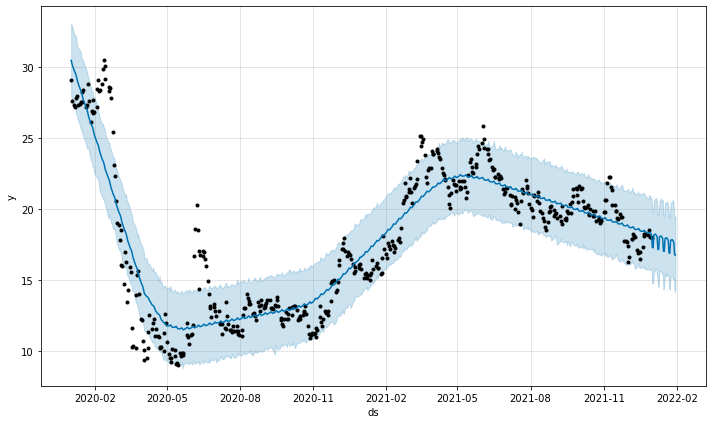

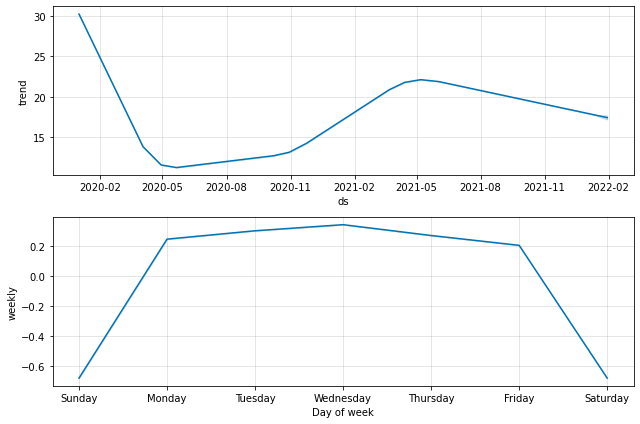

In [160]:
Prophet_prediction_plot(dataframe, periods_q) 


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.0797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       927.448     0.0703249       514.574           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        954.15    0.00156836       162.462     0.07117       0.675      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       975.114    0.00114062        85.423      0.3351           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       975.822    0.00371891       174.085   4.755e-05       0.001      426  LS failed, Hessian reset 
     332       976.235   0.000300178       64.6675   4.314e-06       0.001      489  LS failed, Hessian reset 
     363       976.279   0.000134966       79.0538   1.996e-06       0.001      575  LS failed, Hessian rese

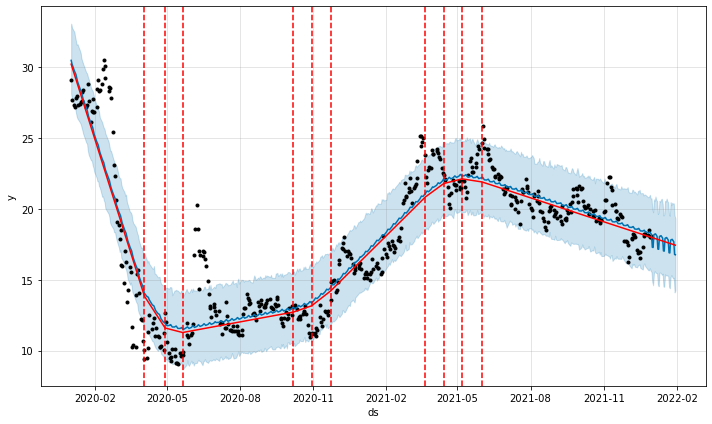

In [161]:
auto_changepoint_detection(dataframe, periods_q)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.0797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       927.448     0.0703249       514.574           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        954.15    0.00156836       162.462     0.07117       0.675      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       975.114    0.00114062        85.423      0.3351           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       975.822    0.00371891       174.085   4.755e-05       0.001      426  LS failed, Hessian reset 
     332       976.235   0.000300178       64.6675   4.314e-06       0.001      489  LS failed, Hessian reset 
     363       976.279   0.000134966       79.0538   1.996e-06       0.001      575  LS failed, Hessian rese

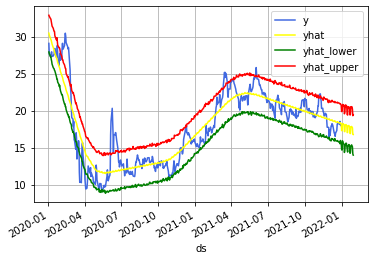

In [162]:
dataframe = prediction_need_table(dataframe)  

estimation_result(dataframe)    

### Trading Strategy Result Shows

In [164]:
# Hold: Our bench mark. Simplest trading strategy, when we predict a stock will rise in price, 
# we hold until the last day of the prediction. 
# Any trading strategy is compared based on this trading strategy. 
# In this case, our theoretical calculation is based primarily on the magnitude of the actual price volatility, 
# which is a cumulative volatility range, 
# and I use '.cumprod()' to calculate it and make a separate column to see the investor's return on unit assets, 
# over a given time period.

holding_strategy_table(dataframe)


,ds,real price percent change,Hold_return on unit assets,suggested strategy
0,2020-01-02,0.000000,1.000000,buy
1,2020-01-03,-0.049502,0.950498,hold
2,2020-01-06,-0.011935,0.939154,hold
3,2020-01-07,-0.003660,0.935717,hold
4,2020-01-08,0.022777,0.957030,hold
...,...,...,...,...
530,2022-01-26,0.000000,0.617394,hold
531,2022-01-27,0.000000,0.617394,hold
532,2022-01-28,0.000000,0.617394,hold
533,2022-01-29,0.000000,0.617394,hold


In [166]:
# Prophet: This strategy is to sell when our forecast indicates a down trend 
# and buy back in when it indicates an upward trend. In this case, 
# I set that when prophet forecasts the closing price for this stock (y_hat) 
# in the next day( t+1 day) is less than the closing price (y_hat) of today (t day), 
# I will sell all stocks, and then use the money I get to buy all the stocks on the next trading day (t+1 day). 

data = prophet_strategy_table(dataframe)
data

,ds,y,yhat,yhat_lower,yhat_upper,real price percent change,Prophet Strategy return on unit assets,Prophet Strategy index,suggested Strategy
0,2020-01-02,29.090000,30.477072,27.924764,32.893623,0.000000,NaN,-0.242946,sell and rebuy it tomorrow
1,2020-01-03,27.650000,30.234126,27.718691,32.761477,-0.049502,1.0,-0.492446,sell and rebuy it tomorrow
2,2020-01-06,27.320000,29.741680,27.288423,32.445789,-0.011935,1.0,-0.122329,sell and rebuy it tomorrow
3,2020-01-07,27.219999,29.619351,27.283341,32.379055,-0.003660,1.0,-0.137454,sell and rebuy it tomorrow
4,2020-01-08,27.840000,29.481897,26.919307,32.055703,0.022777,1.0,-0.249534,sell and rebuy it tomorrow
...,...,...,...,...,...,...,...,...,...
530,2022-01-26,NaN,17.853920,15.361651,20.534773,0.000000,1.452362,-0.090081,sell and rebuy it tomorrow
531,2022-01-27,NaN,17.763839,15.195764,20.485340,0.000000,1.452362,-0.083493,sell and rebuy it tomorrow
532,2022-01-28,NaN,17.680346,15.111544,20.199634,0.000000,1.452362,-0.898553,sell and rebuy it tomorrow
533,2022-01-29,NaN,16.781794,14.138023,19.311783,0.000000,1.452362,-0.018362,sell and rebuy it tomorrow


In [167]:
# Prophet Thresh. This strategy is more cautious. 
# If the real price of the previous day (day t-1) is lower than the low value we predicted next day (day t), 
# we will sell it all on the previous day (day t-1) and rebuy it again the next day(day t) with all the money.

data = prophet_thresh_strategy_table(dataframe)
data

,ds,y,yhat,yhat_lower,yhat_upper,real price percent change,Prophet Thresh Strategy return on unit assets,Prophet Thresh Strategy index,suggested Strategy
0,2020-01-02,29.090000,30.477072,27.924764,32.893623,0.000000,0.000000,-0.274765,sell and rebuy it tomorrow
1,2020-01-03,27.650000,30.234126,27.718691,32.761477,-0.049502,1.000000,-0.398692,sell and rebuy it tomorrow
2,2020-01-06,27.320000,29.741680,27.288423,32.445789,-0.011935,1.000000,-0.068424,sell and rebuy it tomorrow
3,2020-01-07,27.219999,29.619351,27.283341,32.379055,-0.003660,1.000000,0.556659,hold
4,2020-01-08,27.840000,29.481897,26.919307,32.055703,0.022777,1.022777,1.030694,hold
...,...,...,...,...,...,...,...,...,...
530,2022-01-26,NaN,17.853920,15.361651,20.534773,0.000000,2.158440,NaN,lack yesterday real closing price
531,2022-01-27,NaN,17.763839,15.195764,20.485340,0.000000,2.158440,NaN,lack yesterday real closing price
532,2022-01-28,NaN,17.680346,15.111544,20.199634,0.000000,2.158440,NaN,lack yesterday real closing price
533,2022-01-29,NaN,16.781794,14.138023,19.311783,0.000000,2.158440,NaN,lack yesterday real closing price


In [168]:
# Prophet Thresh. This strategy is more cautious. 
# If the real price of the previous day (day t-1) is lower than the low value we predicted next day (day t), 
# we will sell it all on the previous day (day t-1) and rebuy it again the next day(day t) with all the money.

data = prophet_thresh_strategy_table(dataframe)
data

,ds,y,yhat,yhat_lower,yhat_upper,real price percent change,Prophet Thresh Strategy return on unit assets,Prophet Thresh Strategy index,suggested Strategy
0,2020-01-02,29.090000,30.477072,27.924764,32.893623,0.000000,0.000000,-0.274765,sell and rebuy it tomorrow
1,2020-01-03,27.650000,30.234126,27.718691,32.761477,-0.049502,1.000000,-0.398692,sell and rebuy it tomorrow
2,2020-01-06,27.320000,29.741680,27.288423,32.445789,-0.011935,1.000000,-0.068424,sell and rebuy it tomorrow
3,2020-01-07,27.219999,29.619351,27.283341,32.379055,-0.003660,1.000000,0.556659,hold
4,2020-01-08,27.840000,29.481897,26.919307,32.055703,0.022777,1.022777,1.030694,hold
...,...,...,...,...,...,...,...,...,...
530,2022-01-26,NaN,17.853920,15.361651,20.534773,0.000000,2.158440,NaN,lack yesterday real closing price
531,2022-01-27,NaN,17.763839,15.195764,20.485340,0.000000,2.158440,NaN,lack yesterday real closing price
532,2022-01-28,NaN,17.680346,15.111544,20.199634,0.000000,2.158440,NaN,lack yesterday real closing price
533,2022-01-29,NaN,16.781794,14.138023,19.311783,0.000000,2.158440,NaN,lack yesterday real closing price


In [169]:
##  profit comparison between different stategies, suppose our initial invest money is $1000

df = strategy_compare(dataframe)
print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")

Hold = 617
Prophet = 2,539
Prophet Thresh = 2,158


<AxesSubplot:xlabel='ds'>

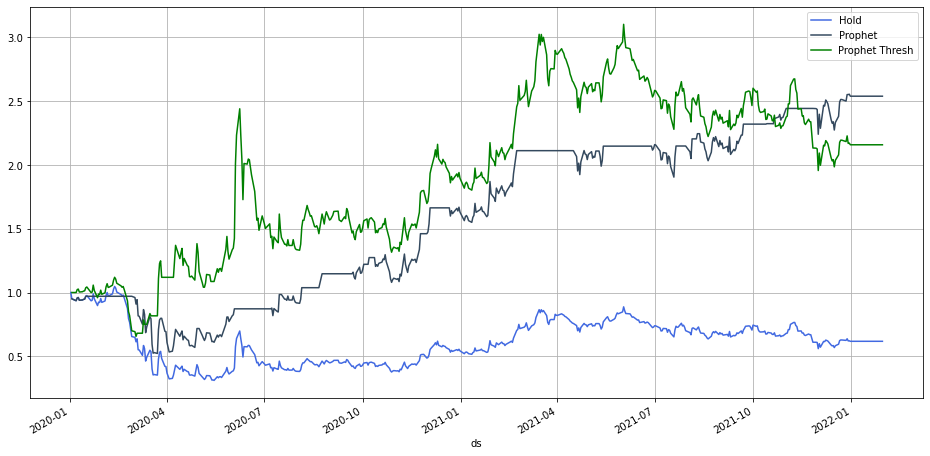

In [170]:

# plot the profit comparison, We can measure our rate of return in real time 
df.set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh']].plot(figsize=(16,8), color=['royalblue', "#34495e", "green", ], grid=True)